# A/B–тестирование новой механики оплаты

### 1.1 Условие
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные
В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import pylab 
import scipy.stats as stats
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import normaltest, anderson, chi2_contingency, norm, shapiro

In [2]:
groups       = pd.read_csv(r'C:\Users\pletn\Documents\notebooks\final_projects\2\groups.csv', sep=';')
groups_add   = pd.read_csv(r'C:\Users\pletn\Documents\notebooks\final_projects\2\group_add.csv', sep=',')
active_studs = pd.read_csv(r'C:\Users\pletn\Documents\notebooks\final_projects\2\active_studs.csv', sep=';')
checks       = pd.read_csv(r'C:\Users\pletn\Documents\notebooks\final_projects\2\checks.csv', sep=';')

### 1.3 Разведочный анализ

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
# Имеются ли дубликаты по id

groups.id.nunique() != groups.shape[0]

False

In [6]:
# Сколько пользователей в каждой группе

groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [7]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [8]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [9]:
# Имеются ли дубликаты по id

groups_add.id.nunique() != groups_add.shape[0]

False

In [10]:
# Сколько пользователей в каждой группе

groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [11]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [13]:
# Имеются ли дубликаты по student_id

active_studs.student_id.nunique() != active_studs.shape[0]

False

In [14]:
# Группы активных пользователей

active_studs.merge(groups.rename(columns={'id': 'student_id'}), how='left', on='student_id')\
            .fillna('not_found')\
            .grp.value_counts()

B            6793
A            1535
not_found      13
Name: grp, dtype: int64

In [15]:
# Для 13 пользователей отсутствует информация. Создадим groups_all

groups_all = pd.concat([groups, groups_add])\
                .rename(columns={'id': 'student_id'})

In [16]:
# Проверим, что никого не потеряли

groups_all.student_id.nunique() == groups.id.nunique() + groups_add.id.nunique()

True

In [17]:
# Имеются ли дубликаты по id

groups_all.student_id.nunique() != groups_all.shape[0]

False

In [18]:
# Группы всех активных пользователей

active_studs.merge(groups_all, how='left', on='student_id')\
            .fillna('not_found')\
            .grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [19]:
# Отлично, никого не потеряли! Идем дальше...
# Группы всех пользователей

groups_all.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [20]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [21]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [22]:
# Количество пользователей совершивших покупку

checks.student_id.nunique()

541

In [23]:
# Описательные статистики трат пользователей

checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [24]:
# Количество пересечений пользователей в checks и groups_total

checks.merge(groups_all.rename(columns={'id': 'student_id'}), how='inner', on='student_id').shape[0]

541

In [25]:
# Количество пересечений пользователей в checks и active_studs

checks.merge(active_studs, how='inner', on='student_id').shape[0]

392

# !!!
### А вот тут важный момент. 
По условию данных в таблице active_studs информация о пользователях, которые зашли в дни эксперимента, а в таблице checks оплаты в дни эксперимента. При джоине таблиц checks и active_studs мы получаем 541 - 392 пользователей, которые совершили оплату в день эксперимента, тоесть присутствуют в таблице checks, но не заходили на сайт в день эксперимента, тоесть их нет в таблице active_studs. Судя по данному поведению сервис предусматривает подписочную модель. Сейчас важно то, что этих пользователей нельзя включать в анализируемую выборку, т.к. они не заходили на сервис и соответственно не увидели нововведение механики оплаты.

In [26]:
# Создадим общий датафрейм всех активных пользователей

abtestdf = active_studs.merge(groups_all.rename(columns={'id': 'student_id'}), how='left', on='student_id')\
                        .merge(checks, how='left', on='student_id').fillna(0)

# Создадим столбец 'cr' где 0 - отсутствие целевого действия (покупки), а 1 - наличие целевого действия

abtestdf['cr'] = abtestdf['rev'].apply(lambda x: 1 if x != 0 else x)

abtestdf.head()

,student_id,grp,rev,cr
0,581585,A,0.0,0.0
1,5723133,A,0.0,0.0
2,3276743,B,0.0,0.0
3,4238589,A,0.0,0.0
4,4475369,B,0.0,0.0


In [27]:
abtestdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   grp         8341 non-null   object 
 2   rev         8341 non-null   float64
 3   cr          8341 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 325.8+ KB


In [28]:
# Количество пользователей совершивших покупку и общее число пользователей по группам

cr_table = abtestdf.query('rev > 0').groupby('grp').agg({'student_id' : 'count'}).rename(columns = {'student_id' : 'paiment_users'})
cr_table = cr_table.merge(abtestdf.groupby('grp').agg({'student_id' : 'count'}), on = 'grp').rename(columns = {'student_id' : 'all_users'})
cr_table

,paiment_users,all_users
grp,,
A,78,1538
B,314,6803


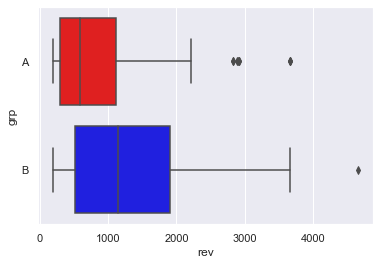

In [29]:
# Распределение трат пользователей по группам

sns.set(rc={'figure.figsize':(16,3)})
colors = ['red', 'blue']
sns.set_palette(colors)
sns.boxplot(data=abtestdf, x=abtestdf.query('rev > 0').rev, y=abtestdf.grp, orient="h");

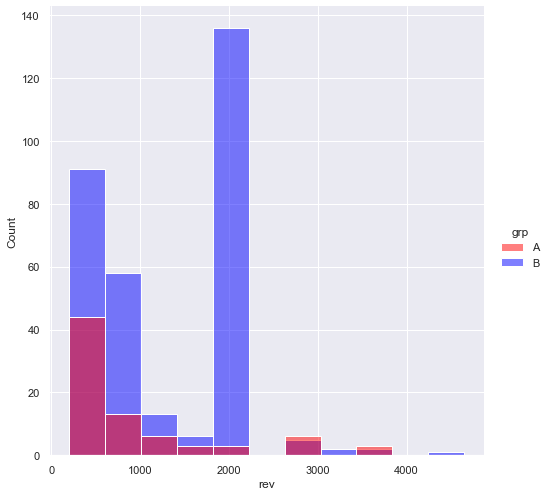

In [30]:
# Частотная гистограмма трат пользователей групп А и В (без нулей)

sns.displot(data=abtestdf.query('rev > 0')[['rev', 'grp']], 
            x='rev', hue='grp', height=7, aspect=1);

In [31]:
# ТОП5 часто встречаемых трат пользователей в группе В

abtestdf.query('rev > 0 & grp == "B"')['rev'].value_counts().head(5)

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
Name: rev, dtype: int64

In [32]:
# ТОП5 часто встречаемых трат пользователей в группе А

abtestdf.query('rev > 0 & grp == "A"')['rev'].value_counts().head(5)

290.0    25
580.0     6
990.0     5
590.0     5
199.0     5
Name: rev, dtype: int64

### 1.3.1 Результаты разведочного анализа:
1. Файл groups содержит данные о 74484 пользователях, из которых 14671 принадлежит к группе А  и 59813 к группе B. В Файле нет данных о группах для 13 пользователей.
2. Исходя из условий новая механика оплаты была предложена целевой группе B, контрольная группа А со старой механикой. Контрольная группа на порядок меньше тестовой, что может свидетельствовать о том, что проводился обратный A/B тест. Изначально изменение уже было внедрено для всех пользователей, а после решили понять насколько оно эффективно и для небольшой контрольной группы А изменения откатили.
3. В дополнительном файле имеется информация о 92 пользователях, 70 из группы A и 22 из группы B. Файлы groups + groups_add содержат данные о группах всех пользователей, участвовавших в A/B тесте. 
4. Будем считать, что генеральная совокупность - это все пользователи, содержащиеся в файлах groups и groups_add - 74576 пользователей, 59883 группа B и 14693 группа А.
5. Выборкой будем считать пользователей, посетивших сайт во время эксперимента (active_studs), участники A/B теста - 8341 пользователей, группа А - 1538, группа В - 6803. Количество пользователей, совершивших покупку в группе А - 78, в группе В - 314.
6. Файл с информацией об оплатах checks содержит данные о 541 пользователе, из которых 392 участвовали в A/B тесте (заходили на платформу в дни проведения эксперимента). Остальные 149 пользователей не заходили на платформу, но совершили оплату, что может свидетельствовать о том, что платформа предусматривает подписочную модель. Эти 149 пользователей не включены в выборку для анализа результатов A/B теста, т.к. не взаимодействовали с платформой.
7. Мода оплаты пользователей в группе А = 1900 рублей, и встречается 128 раз из 314 (41%). В группе В мода = 290 рублей и встречается 25 раз из 78 (32%). Такой высокий процент значения моды так же дополнительный аргумент в пользу того, что платформа предусматривает подписочную модель.

### 1.4 Выбор и расчет метрик.

По имеющимся данным мы можем определить:
- ARPU - средний доход принесенный пользователем 
- ARPPU - средний доход с платящего пользователя 
- CR -конверсию в покупку

In [33]:
# Создадим для каждой метрики и группы массив данных для удобства дальнейшей работы 

ARPPU_a = abtestdf.query('grp == "A" & rev > 0')['rev']
ARPPU_b = abtestdf.query('grp == "B" & rev > 0')['rev']
ARPU_a = abtestdf.query('grp == "A"')['rev']
ARPU_b = abtestdf.query('grp == "B"')['rev']
CR_a = abtestdf.query('grp == "A"')['cr']
CR_b = abtestdf.query('grp == "B"')['cr']

In [34]:
metrics = {'ARPU' : [ARPU_a.mean(), ARPU_b.mean()],\
           'ARPPU' : [ARPPU_a.mean(), ARPPU_b.mean()], \
           'CR' : [CR_a.mean(), CR_b.mean()]}

pd.DataFrame(data=metrics, index=['a', 'b'])

,ARPU,ARPPU,CR
a,47.347204,933.589744,0.050715
b,58.058798,1257.878992,0.046156


### 1.5 Формирование гипитез и выбор уровня значимости

# ARPU = CR * ARPPU

В ходе тестирования будем проверять изменчивость метрик CR и ARPPU, как метрик-компонент ARPU.

Будем проверять две гипотезы:
1. Н0: ARPPU_A = ARPPU_B. H1: ARPPU(A) < ARPPU(B).
2. Н0: CR_A = CR_B. H1: CR(A) > CR(B).

Уровень значимости α = 0.05

### 1.6 Выбор статистических тестов
1. ARPPU - среднее, оценим возможность применения t-test. 
2. CR - категориальная переменная, будем использовать критерий хи-квадрат.

Для оценки возможности применения t-test убедимся:
1. В гомогенности дисперсий с помощью критерия Левена α = 0.05.
2. Так как выборки для расчета ARPPU относительно небольшие (78 значений для группы А и 314 для группы В) и в группе А имеются пользователи которые совершили покупки на суммы значительно большие, чем средние значения, необходимо убедиться, что распределение средних является нормальным. Будем проверять с помощью теста Шапиро-Уилка α = 0.05.

In [35]:
# Проверим гомогенность дисперсий

scipy.stats.levene(ARPPU_a, ARPPU_b)

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

p-value > α. Н0 о гомогенности дисперсий не отвергаем.

Для проверки Н0 о нормальности средних засимулируем 5000 выборок с возвращениями (количество значений в выборке равно количеству значений в группах А и В), чтобы в дальнейшем проверить тестом Шапиро-Уилка.

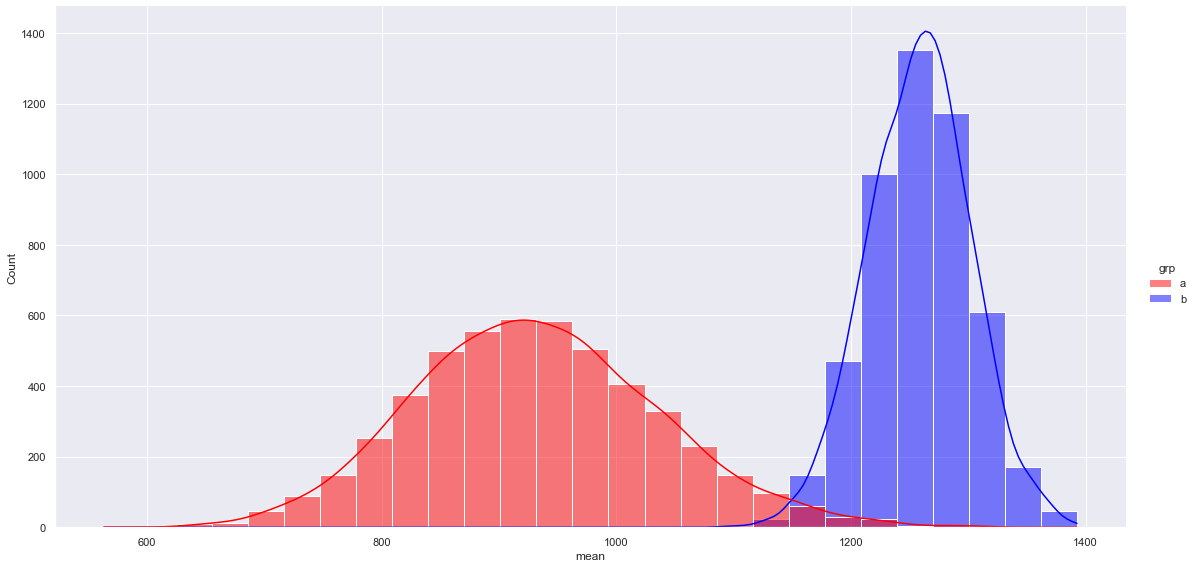

In [36]:
ARPPU_mean_a = []
ARPPU_mean_b = []

sample_size_a = len(ARPPU_a)
sample_size_b = len(ARPPU_b)

for i in range(5000):
    
    ARPPU_mean_a.append(ARPPU_a.sample(sample_size_a, replace=True).mean()) 
    ARPPU_mean_b.append(ARPPU_b.sample(sample_size_b, replace=True).mean())

a = pd.DataFrame(data = ARPPU_mean_a, columns = ['mean'])
a['grp'] = 'a'
b = pd.DataFrame(data = ARPPU_mean_b, columns = ['mean'])
b['grp'] = 'b'
AB_means = pd.concat([a, b]).reset_index()

sns.displot(data=AB_means, x='mean', hue='grp', height=8, aspect=2, kde = True);

In [37]:
shapiro(ARPPU_mean_a)

ShapiroResult(statistic=0.9970639944076538, pvalue=2.6427549926211213e-08)

In [38]:
shapiro(ARPPU_mean_b)

ShapiroResult(statistic=0.9993551969528198, pvalue=0.07159490883350372)

Среднее в группе А распределено не нормально (p-value < α). Это следтсвие присутствия в выборке пользователей, которые потратили значительно больше, чем остальные, а так же малым размером выборки. Таких пользователей "выбросами" считать нельзя, поэтому не будем их удалять из выборки. При этом распредление средних ARPPU в группе В нормальное. В связи с тем, что не удволетворяется критерии нормальности для применения t-test, для проверки гипотезы о равенстве ARPPU будем использовать bootstrap.

### 1.7 Статистическая проверка гипотез

### 1.7.1 Проверка гипотезы Н0: ARPPU_A = ARPPU_B. H1: ARPPU(A) < ARPPU(B).

Возьмем 10000 подвыборок с возвращениями из выборок А и В и в каждой выборке посчитаем разность средних.

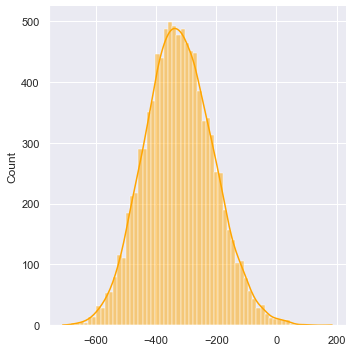

In [39]:
AB_mean_delta = []

for i in range(10000):
    
    AB_mean_delta.append(ARPPU_a.sample(sample_size_a, replace=True).mean() \
                         - ARPPU_b.sample(sample_size_b, replace=True).mean())

sns.displot(AB_mean_delta, color = 'orange', kde = True);

In [40]:
# Т.к. наша альтернативная гипотеза звучит как ARPPU(A) < ARPPU(B) возьмем только правый хвост

pd.DataFrame(AB_mean_delta).quantile(0.95)

0   -134.082849
Name: 0.95, dtype: float64

*Вывод:* Так как 0 не попадает в границы доверительного интервала ($-\infty$; -97.66] нулевая гипотеза о равенстве ARPU в группах А и В отклоняется и принимается альтернативная ARPPU(A) < ARPPU(B).

### 1.7.2. Проверка гипотезы Н0: CR_A = CR_B. H1: CR(A) > CR(B).

Используем ранее созданную таблицу с данными по конверсии cr_table:

In [41]:
chi2_contingency(cr_table)

(0.43612258061018483,
 0.5089998823014525,
 1,
 array([[  72.53773045, 1543.46226955],
        [ 319.46226955, 6797.53773045]]))

*Вывод:* Так как p-value > ранее принятого уровня значимости 0.05 нулевая гипотеза о CR_A = CR_B не отвергается.

# 1.8 Выводы

Проведен статистический анализ данных A/B теста с новой механикой оплаты услуг на сайте.

**Сформулированы две гипотезы:**
1. Н0: ARPPU_A = ARPPU_B. H1: ARPPU(A) < ARPPU(B).
2. Н0: CR_A = CR_B. H1: CR(A) > CR(B).

**Проверка гипотез осуществлялась для уровня значимости:**
- α = 0.05

**Выбраны тесты для проверки гипотез:**
1. Для ARPPU выбран bootstrap. 
2. Для CR выбран критерий хи-квадрат.

**Результаты проверки гипотез:**
1. p-value < α. Принимается H1: ARPPU(A) < ARPPU(B).
2. p-value > α. Н0: CR_A = CR_B не отклоняется. 

**Итоговый вывод:**
По результатам A/B теста новая механика оплаты увеличила ARPPU и как следствие ARPU, CR без изменений. Т.к. новая механика оплаты уже внедрена, откатывать назад изменения не стоит.

*Дополнительные рекомендации:*
Так как отсутствует контекст проведения A/B теста, что именно за сервис и как именно изменилась механика оплаты, следующая информация в виде предположений. Возможно сервис построен на подписочной модели, т.к. мода затрат пользователей в группе А = 1900 рублей, и встречается 128 раз из 314 (41%), в группе В мода = 290 рублей и встречается 25 раз из 78 (32%). Так же в пользу этой версии говорит факт того, что имеются пользователи не заходившие на сайт во время A/B теста, но совершившие оплату.
Если речь идет о введении нового тарифа, например, 1900 рублей за 8 месяцев для тестовой группы, а для контрольной был доступен только 290 рублей в месяц, то в этом случае рекомендуется продолжить отслеживать движение ARPPU на дистанции больше, чем действие нового тарифа.